In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
df = pd.read_csv("UsArrests.csv", index_col='City')

In [75]:
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


In [76]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 4


We then need to summarise the statistical properties of the columns:

In [77]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


We also need to determine if we have any missing values, and which features these occur for:

In [78]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [79]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


To visualise the distribution of the observations for each feature, we plot a histogram using Pandas's ```.hist()``` function:

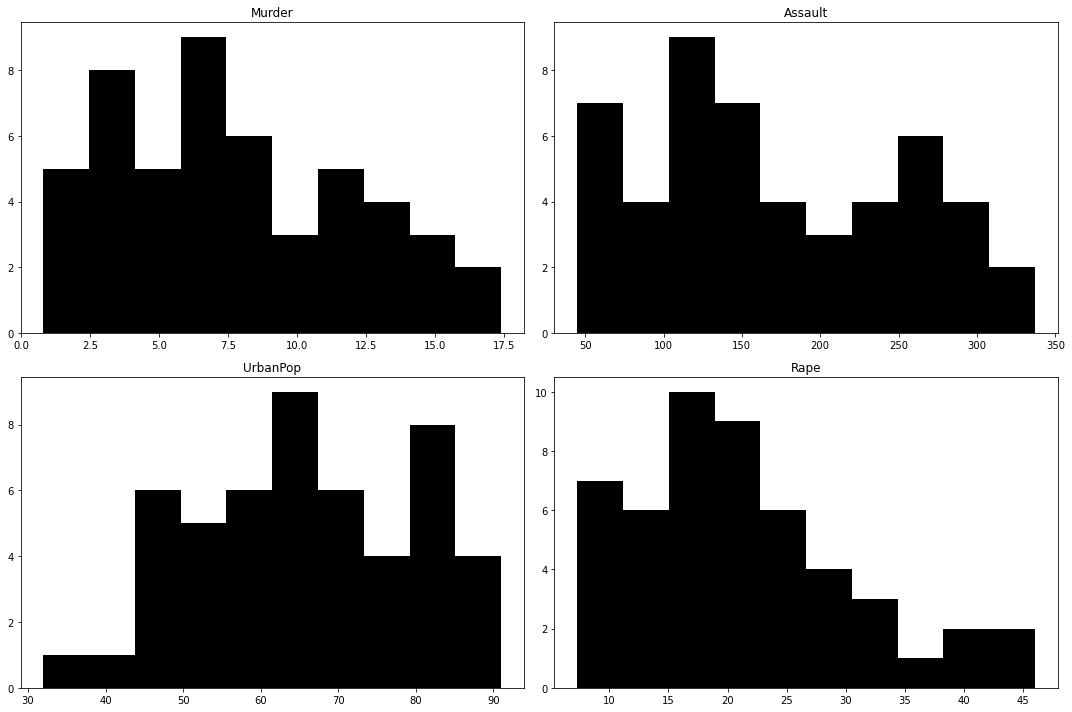

In [80]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

In [81]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


At first glance, the Assault and urban pop variables stands out as having a mean and standard deviation which is dramatically higher than the other variables. This makes sense as most of the other variables are much less common crimes. This indicates that scaling the data will be useful to keep these from impacting the analysis disproportionately.

### Correlation Analysis

In [83]:
states = df.index
corr_df = df.corr()
labels =corr_df.columns

correlations = corr_df.corr()

<AxesSubplot:>

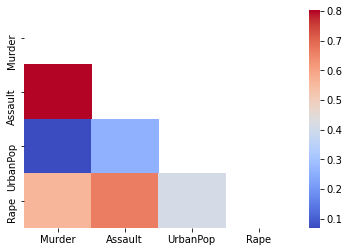

In [84]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

In the plot, there is a linear correlation between strongly correlated variables: those coloured in dark red. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other. No variables are negatively correlated.

The variables that are most correlated are murder and assault, this makes sense as they are fairly similar crimes, then murder and rape/ assault and rape are quite highly correlated which also makes sense. Ubran population does not correlate very strongly with any of the crimes though there is a slighy correlation which means that as populations increase these crimes also increase with the execption of rape. Though urban population and murder and least correlated.

### PCA

In [85]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [86]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [87]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [88]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [89]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

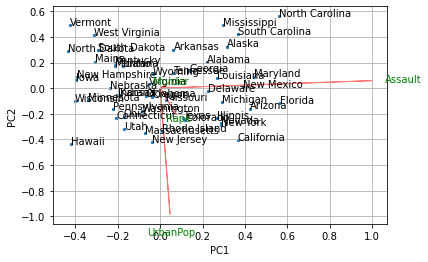

In [90]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From this biplot, we see that assault and urban population are the most important features as the arrows to each of these dominate the biplot.

This information can also be quantified as follows:

In [91]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


We see that the Assauly has by far the highest importance in the first principle component, while two features are relatively important for the second component: UrbanPop and Rape. These observations agree with those deduced from the biplot. If we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

### Standardise the data

We standardise the data so that some features do not swamp the others.

In [92]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


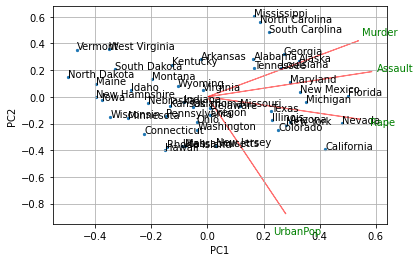

In [93]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the crimes are clustered together whereas urbanpop is removed.

In [94]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance.

Text(0.5, 1.0, 'Cumulative Explained Variance')

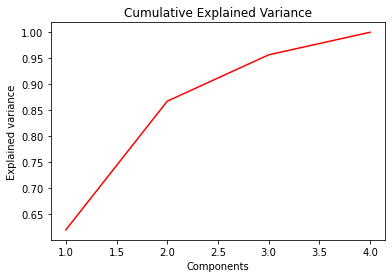

In [95]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

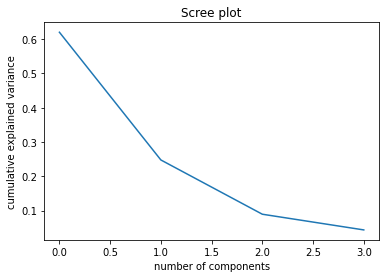

In [96]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 principal components together explain around 87% of the variance. We can therefore use them to perform cluster analysis.

In [97]:
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


### Hierarchical clustering

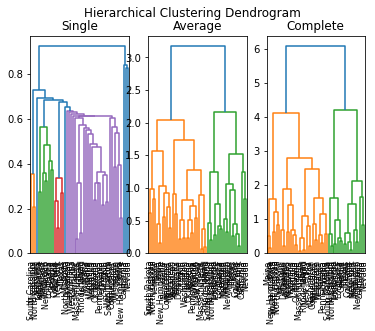

In [98]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Both average and complete linkages create balanced dispertion of clusters and so we choose average since it will run faster.

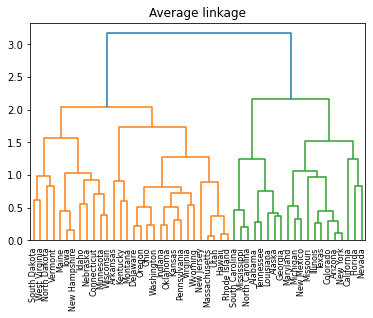

In [99]:
plt.title("Average linkage")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.show()

### K-means clustering

No handles with labels found to put in legend.


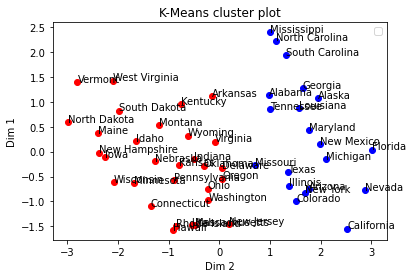

In [100]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=7)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rb'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()